In [1]:
# Data Handlers
import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageOps

# Pytorch
import torch
import torch.nn as nn  # NN; networks (CNN, RNN, losses)
import torch.optim as optim  # Optimizers (Adam, Adadelta, Adagrad)
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, IterableDataset  # Dataset manager
from torch.autograd import Variable
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn.functional import one_hot

# Other
import datetime
import os
from tqdm import tqdm
from pathlib import Path
from os import listdir
from fastaniso import anisodiff
from time import time


# Graphics
from matplotlib import pyplot as plt
import seaborn as sns


from skimage.metrics import structural_similarity as ssim
from sklearn.preprocessing import OneHotEncoder

# Additional modules
from dataset_creator import generate_csv
from assistive_funcs import filtering_image, check_ssim, check_gmsd, convert_to_grayscale, get_dataset_name
from csv_dataloader import get_train_test_big_data, get_train_test_small_data
from math import floor

d:\Projects\PythonProjects\_venvs\3.9_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Paths
p_main_data = Path("../data")
p_models = Path("../models")

p_scv_folder = p_main_data / "csv_files" # datasets_path
p_img = p_main_data / "images"

p_noised_imgs = p_main_data / "FC_imgs_with_noise"

p_filtered_images = p_main_data / "FC_filtered_images"

p_gray_images = p_main_data / "gray_images"

In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"{dataset_name = }\n{device = }")
device

device(type='cuda')

In [4]:
# Dataset
win_size = 7
step = 5
create_dataset = 0
if create_dataset:
    generate_csv(win_size=win_size, dump_to_file=5000, step=step, force_create_dataset=1, classification=True)

In [5]:
win_size = 7
step = 5

dataset_name = get_dataset_name(win_size, step, p_scv_folder, classification=True) #r"W5_S1_L3696640.csv"
dataset_name

'classification\\W7_S5_L146410.csv'

In [6]:
# from google.colab import drive
# drive.mount('/content/gdrive/')
# !unzip -q /content/gdrive/MyDrive/NIR/data/FC_data/W5_S5_L146410.zip


In [7]:
class FCBlock(nn.Module):
    def __init__(self, in_len, out_len) -> None:
        super().__init__()
        self.fc_block = nn.Sequential(
            nn.Linear(in_len, out_len),
            nn.BatchNorm1d(out_len),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.fc_block(x)
        

class DefaultModel(nn.Module):
    def __init__(self, in_len, out_len) -> None:
        super().__init__()
        double_in_len = in_len * 2

        self.structure = nn.Sequential(
            FCBlock(in_len, in_len),

            FCBlock(in_len, double_in_len),
            # nn.Dropout(0.5),

            FCBlock(double_in_len, double_in_len),
            # nn.Dropout(0.5),

            FCBlock(double_in_len, in_len),
            # nn.Dropout(0.5),

            nn.Linear(in_len, out_len)
        )

    def forward(self, x):
        x = self.structure(x)
        return x

In [8]:
# losses = []
# losses_append = losses.append

# valid_losses = []
# valid_losses_append = valid_losses.append

# for epoch in range(num_epoches):
#     model.train()
#     train_loader, test_loader = get_train_test_data(scv_folder=p_scv_folder, dataset_name=dataset_name, batch_size=batch_size, train_size=0.8)
#     for batch_ind, (data, targets) in tqdm(enumerate(train_loader)):
#         # Data on cuda
#         data = data.to(device=device)
#         targets = targets.to(device=device)
        
#         # Forward
#         scores = model(data) # Equal to model.forward(data)
#         loss = criterion(scores, targets)

#         # Backprop
#         loss.backward()

#         # Gradient descent or adam step
#         optimizer.step()
#         optimizer.zero_grad()
        
#         if batch_ind % 3 == 0:
#             losses_append(loss.item())
#     scheduler.step()
#     model.eval()
#     with torch.no_grad():
#         for batch_ind, (data, targets) in tqdm(enumerate(test_loader)):
#             data = data.to(device=device)
#             targets = targets.to(device=device)
            
#             # Forward
#             scores = model(data) # Equal to model.forward(data)
#             loss = criterion(scores, targets)
#             valid_losses_append(loss.item())

In [9]:
class FitModel():
    def __init__(self, model, criterion, optimizer, scheduler, p_scv_folder, dataset_name, batch_size, device, num_epoches) -> None:
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.num_epoches = num_epoches
        self.p_scv_folder = p_scv_folder
        self.dataset_name = dataset_name
        self.batch_size = batch_size
        self.train_losses = []
        self.valid_losses = []
        self.device = device  
        
        X = [[i] for i in range(0, 256)]
        self.enc = OneHotEncoder()
        self.enc.fit(X)
        

# loop = tqdm(enumerate(self.val_loader, start=1),
#                     leave=True,
#                     total=len(self.val_loader))

#                 loop.set_description(f"Valid epoch: {current_epoch}")
#                 loop.set_postfix(loss=round(loss.item(), 2))


    def _train(self, current_epoch):
        loop = tqdm(enumerate(self.val_loader, start=1),
            leave=True,
            total=len(self.val_loader))
        self.model.train()
        total_loss = []
        for batch_index, (data, targets) in tqdm(enumerate(self.train_loader, start=1)):
            data = data.to(device=self.device)
            targets = torch.Tensor(self.enc.transform(targets).toarray())
            targets = targets.to(device=self.device)
            # print(targets)
            # print(data)
            scores = self.model(data)
            loss = self.criterion(scores, targets)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            total_loss.append(loss.item())
        self.train_losses.append(np.mean(total_loss))
        
    def _valid(self, current_epoch):
        total_loss = []
        self.model.eval()
        with torch.no_grad():
            for batch_index, (data, targets) in tqdm(enumerate(self.test_loader, start=1)):
                data = data.to(device=self.device)
                targets = torch.Tensor(self.enc.transform(targets).toarray())
                targets = targets.to(device=self.device)
                
                # Forward
                scores = self.model(data) # Equal to model.forward(data)
                loss = self.criterion(scores, targets)
                total_loss.append(loss.item())
        self.valid_losses.append(np.mean(total_loss))
    
    def fit(self):
        for epoch in range(self.num_epoches):
            self.train_loader, self.test_loader = get_train_test_small_data(scv_folder=self.p_scv_folder, dataset_name=self.dataset_name,
                                                                      batch_size=self.batch_size, train_size=0.8)
            self._train(epoch)
            self._valid(epoch)
            if self.scheduler is not None:
                self.scheduler.step()
                
    def plot_graph(self):
        sns.set()
        fig, (ax_train, ax_test) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
        fig.suptitle('Loss')

        ax_train.set_title("Train loss")
        ax_test.set_title("Valid loss")

        ax_train.set_ylabel('Loss value')
        ax_test.set_ylabel('Loss value')

        ax_train.set_xlabel("Batch")
        ax_test.set_xlabel("Batch")

        sns.lineplot(data=self.train_losses, ax=ax_train)
        sns.lineplot(data=self.valid_losses, ax=ax_test)

        plt.show()
    
    def filtering_all_images(self):
        images_names = listdir(p_noised_imgs)
        for name in images_names:
            filtering_image(self.model, p_filtered_images, p_noised_imgs, name, win_size, self.device, classification=True)


In [10]:
# Hyperparameters 
learning_rate = 0.1
num_epoches = 12
batch_size = 128

model = DefaultModel(in_len=(win_size ** 2), out_len=256).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.2)

In [11]:
fit_model = FitModel(model, criterion, optimizer, scheduler, p_scv_folder, dataset_name, batch_size, device, num_epoches)
fit_model.fit()

916it [00:09, 99.78it/s] 
229it [00:00, 337.02it/s]
916it [00:07, 130.24it/s]
229it [00:00, 331.90it/s]
916it [00:07, 129.45it/s]
229it [00:00, 316.48it/s]
916it [00:06, 133.29it/s]
229it [00:00, 365.43it/s]
916it [00:06, 133.47it/s]
229it [00:00, 366.60it/s]
916it [00:07, 130.06it/s]
229it [00:00, 372.21it/s]
916it [00:06, 133.61it/s]
229it [00:00, 368.43it/s]
916it [00:06, 132.76it/s]
229it [00:00, 371.37it/s]
916it [00:06, 133.42it/s]
229it [00:00, 371.97it/s]
916it [00:07, 114.90it/s]
229it [00:00, 272.12it/s]
916it [00:06, 133.17it/s]
229it [00:00, 357.72it/s]
916it [00:06, 135.98it/s]
229it [00:00, 375.01it/s]


In [12]:
a = torch.randn(4, 4)
a

tensor([[-0.8359,  0.5870, -1.5141, -0.7106],
        [ 0.9139, -0.5761,  0.1068, -0.2097],
        [ 1.2137,  1.1610,  0.0955,  1.0960],
        [-0.9848, -0.9291,  0.8892,  0.1749]])

In [13]:
a.argmax(axis=-1).flatten()

tensor([1, 0, 0, 2])

In [14]:
# def Train(model, optimizer, loss, epochs, TrainDataloader, ValidDataloader,train_loss_list, train_acc_list,valid_loss_list, valid_acc_list, device):
#     for epoch in range(epochs):
#         print(f"Epoch {epoch+1}/{num_epochs}")
#         start_time = datetime.now()
#         train_loss = []
#         pred_labels = []
#         true_labels = []
#         model.train()
#         optimizer.zero_grad()
#         for train_x, train_y in TrainDataloader:
#             x = train_x.to(device)
#             true_y = train_y.to(device)
#             pred_y = model(x)
#             loss_train_res = loss(pred_y, true_y)
#             batch_train_loss = loss_train_res.cpu().item()
#             train_loss.append(batch_train_loss)
#             loss_train_res.backward()
#             optimizer.step()
#             optimizer.zero_grad()
#             pred_labels += pred_y.argmax(axis=-1).flatten().tolist()
#             true_labels += true_y.tolist()
#         train_loss_mean = np.mean(train_loss)
#         train_acc = accuracy_score(true_labels, pred_labels)
#         train_loss_list.append(train_loss_mean)
#         train_acc_list.append(train_acc)
#         valid_loss = []
#         pred_labels = []
#         true_labels = []
#         model.eval()
#         with torch.no_grad():
#             for valid_x, valid_y in ValidDataloader:
#                 x = valid_x.to(device)
#                 true_y = valid_y.to(device)
#                 pred_y = model(x)
#                 loss_valid_res = loss(pred_y, true_y)
#                 batch_val_loss = loss_valid_res.cpu().item()
#                 valid_loss.append(batch_val_loss)
#                 pred_labels += pred_y.argmax(axis=-1).flatten().tolist()
#                 true_labels += true_y.tolist()
#         valid_loss_mean = np.mean(valid_loss)
#         valid_acc = accuracy_score(true_labels, pred_labels)
#         valid_loss_list.append(valid_loss_mean)
#         valid_acc_list.append(valid_acc)
#         print(f"Train Loss: {train_loss_mean:.5f}, Train Accuracy = {train_acc}")
#         print(f"Valid Loss: {valid_loss_mean:.5f}, Valid Accuracy = {valid_acc}")
#         print(f"Time: {datetime.now() - start_time}")

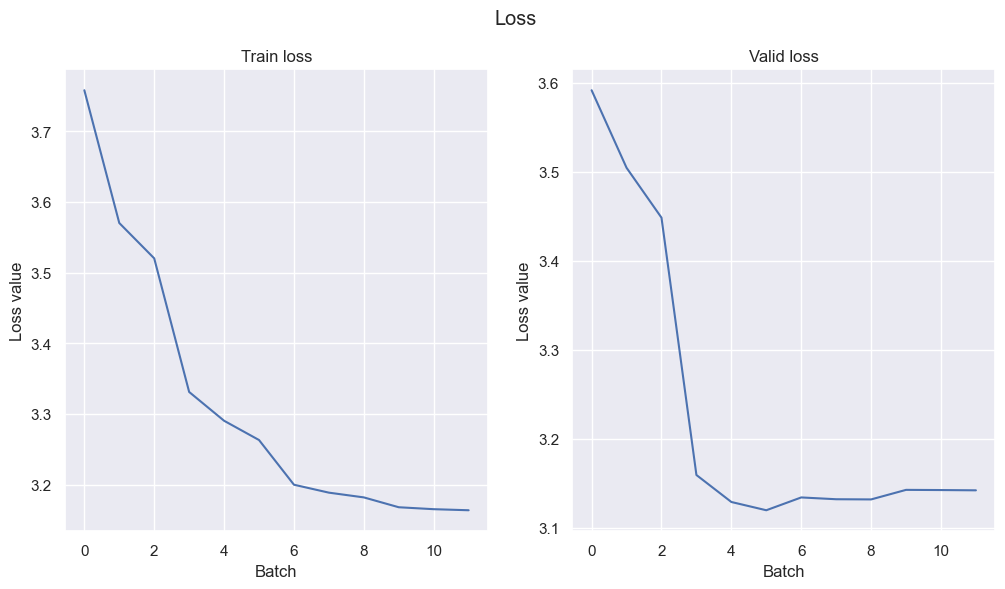

In [15]:
fit_model.plot_graph()

In [21]:
fit_model.filtering_all_images()

100%|██████████| 608/608 [00:02<00:00, 288.43it/s]


In [22]:
def check_without_filtering():
    images_names = listdir(p_noised_imgs)
    ssim_metric = []
    gmsd_metric = []
    for name in images_names:
        ssim_metric.append(check_ssim(p_noised_imgs, p_img, name))
        gmsd_metric.append(check_gmsd(p_noised_imgs, p_img, name))
    print(f"SSIM avg: {sum(ssim_metric) / len(ssim_metric)}")
    print(f"GMSD avg: {sum(gmsd_metric) / len(gmsd_metric)}")
    
        
def check_after_filtering():
    ssim_metric = []
    gmsd_metric = []
    images_names = listdir(p_noised_imgs)
    for name in images_names:
        ssim_metric.append(check_ssim(p_filtered_images, p_img, name))
        gmsd_metric.append(check_gmsd(p_filtered_images, p_img, name))
    print(f"SSIM avg: {sum(ssim_metric) / len(ssim_metric)}")
    print(f"GMSD avg: {sum(gmsd_metric) / len(gmsd_metric)}")
        


In [23]:
check_after_filtering()

SSIM avg: 0.8826396950809832
GMSD avg: 0.07269592596550042


In [24]:
check_without_filtering()

SSIM avg: 0.49574680960092926
GMSD avg: 0.13367842907173574


In [25]:
# p_img = p_raw_image / list_images[2]
# img_arr = np.array(ImageOps.grayscale(Image.open(p_img)))
# niters = [1, 2, 5, 10, 20]
# kappa = [1, 5, 10, 50, 100]
# for i in niters:
#     for k in kappa:
#         img_filtered = anisodiff(img_arr, niter=i, kappa=k)
#         img_filtered = img_filtered.astype(np.uint8)
#         Image.fromarray(img_filtered).save(f"{p_img}_I{i}_K{k}.jpg")